#### Copyright 2018 Google LLC.

In [49]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

#Intro to Modeling


**Learning Objectives:**
* Become familiar with pandas for handling small datasets
* Use the tf.Estimator and Feature Column API to experiment with feature transformations
* Use visualizations and run experiments to understand the value of feature transformations

Please **make a copy** of this Colab notebook before starting this lab. To do so, choose **File**->**Save a copy in Drive**.

## Setup

Let's start by importing our dependencies.

In [50]:
!pip install tensorflow==2.15
%reset -f
import numpy as np
import pandas as pd
import math

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

## Pandas, a helpful data analysis library for in-memory dataset

We use a package called [Pandas](http://pandas.pydata.org/) for reading in our data, exploring our data and doing some basic processing. It is really helpful for datasets that fit in memory! And it has some nice integrations, as you will see.

First we set up some options to control how items are displayed and the maximum number of rows to show when displaying a table.  Feel free to change this setup to whatever you'd like.

In [51]:
# Set pandas output display to have one digit for decimal places and limit it to
# printing 15 rows.
pd.options.display.float_format = '{:.2f}'.format
pd.options.display.max_rows = 15

### Load the dataset with pandas
The car data set we will be using in this lab is provided as a comma separated file without a header row.  In order for each column to have a meaningful header name we must provide it.  We get the information about the columns from the [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/automobile).

We will use the features of the car, to try to predict its price.


In [52]:
# Provide the names for the columns since the CSV file with the data does
# not have a header row.
feature_names = ['symboling', 'normalized-losses', 'make', 'fuel-type',
        'aspiration', 'num-doors', 'body-style', 'drive-wheels',
        'engine-location', 'wheel-base', 'length', 'width', 'height', 'weight',
        'engine-type', 'num-cylinders', 'engine-size', 'fuel-system', 'bore',
        'stroke', 'compression-ratio', 'horsepower', 'peak-rpm', 'city-mpg',
        'highway-mpg', 'price']


# Load in the data from a CSV file that is comma separated.
car_data = pd.read_csv('https://storage.googleapis.com/mledu-datasets/cars_data.csv',
                        sep=',', names=feature_names, header=None, encoding='latin-1')


# We'll then randomize the data, just to be sure not to get any pathological
# ordering effects that might harm the performance of Stochastic Gradient
# Descent.
car_data = car_data.reindex(np.random.permutation(car_data.index))

print("Data set loaded. Num examples: ", len(car_data))


Data set loaded. Num examples:  205


This is a really small dataset! Only 205 examples.

For simplicity in this codelab, we do not split the data further into training and validation. But you MUST do this on real datasets, or else you will overfit to your single dataset.

## Task 0: Use pandas to explore and prepare the data

- Use Pandas to inspect the data and manually curate a list of numeric_feature_names and categorical_feature_names.


Useful functions:
- `type()` called on any Python object describes the type of the object
- `dataframe[4:7]` pulls out rows 4, 5, 6 in a Pandas dataframe
- `dataframe[['mycol1', 'mycol2']]` pulls out the two requested columns into a new Pandas dataframe
- `dataframe['mycol1']` returns a Pandas series -- not a dataframe!
- `dataframe.describe()` prints out statistics for each dataframe column

In [53]:
car_data[4:7]

,symboling,normalized-losses,make,fuel-type,aspiration,num-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
63,0,?,mazda,diesel,std,?,sedan,fwd,front,98.80,...,122,idi,3.39,3.39,22.70,64,4650,36,42,10795
118,1,119,plymouth,gas,std,two,hatchback,fwd,front,93.70,...,90,2bbl,2.97,3.23,9.40,68,5500,37,41,5572
111,0,161,peugot,gas,std,four,sedan,rwd,front,107.90,...,120,mpfi,3.46,2.19,8.40,95,5000,19,24,15580


In [54]:
LABEL = 'price'

numeric_feature_names = ['symboling', 'normalized-losses', 'wheel-base',
        'length', 'width', 'height', 'weight', 'engine-size', 'horsepower',
        'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke',
         'compression-ratio']

categorical_feature_names = list(set(feature_names) - set(numeric_feature_names) - set([LABEL]))

# The correct solution will pass these assert statements.
assert len(numeric_feature_names) == 15
assert len(categorical_feature_names) == 10

In [55]:
# Run to inspect numeric features.
car_data[numeric_feature_names]

,symboling,normalized-losses,wheel-base,length,width,height,weight,engine-size,horsepower,peak-rpm,city-mpg,highway-mpg,bore,stroke,compression-ratio
152,1,74,95.70,158.70,63.60,54.50,2015,92,62,4800,31,38,3.05,3.03,9.00
25,1,148,93.70,157.30,63.80,50.60,1989,90,68,5500,31,38,2.97,3.23,9.40
102,0,108,100.40,184.60,66.50,56.10,3296,181,152,5200,17,22,3.43,3.27,9.00
156,0,91,95.70,166.30,64.40,53.00,2081,98,70,4800,30,37,3.19,3.03,9.00
63,0,?,98.80,177.80,66.50,55.50,2443,122,64,4650,36,42,3.39,3.39,22.70
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127,3,?,89.50,168.90,65.00,51.60,2756,194,207,5900,17,25,3.74,2.90,9.50
189,3,?,94.50,159.30,64.20,55.60,2254,109,90,5500,24,29,3.19,3.40,8.50
87,1,125,96.30,172.40,65.40,51.60,2403,110,116,5500,23,30,3.17,3.46,7.50
163,1,168,94.50,168.70,64.00,52.60,2169,98,70,4800,29,34,3.19,3.03,9.00


In [56]:
# Run to inspect categorical features.
car_data[categorical_feature_names]

,make,engine-type,aspiration,fuel-system,fuel-type,drive-wheels,engine-location,num-cylinders,num-doors,body-style
152,toyota,ohc,std,2bbl,gas,fwd,front,four,four,hatchback
25,dodge,ohc,std,2bbl,gas,fwd,front,four,four,sedan
102,nissan,ohcv,std,mpfi,gas,fwd,front,six,four,wagon
156,toyota,ohc,std,2bbl,gas,fwd,front,four,four,sedan
63,mazda,ohc,std,idi,diesel,fwd,front,four,?,sedan
...,...,...,...,...,...,...,...,...,...,...
127,porsche,ohcf,std,mpfi,gas,rwd,rear,six,two,hardtop
189,volkswagen,ohc,std,mpfi,gas,fwd,front,four,two,convertible
87,mitsubishi,ohc,turbo,spdi,gas,fwd,front,four,four,sedan
163,toyota,ohc,std,2bbl,gas,rwd,front,four,two,sedan


In [57]:
# Coerce the numeric features to numbers. This is necessary because the model
# crashes because not all the values are numeric.
for feature_name in numeric_feature_names + [LABEL]:
  car_data[feature_name] = pd.to_numeric(car_data[feature_name], errors='coerce')

# Fill missing values with 0.
# Is this an OK thing to do? You may want to come back and revisit this decision later.
car_data.fillna(0, inplace=True)

## Task 1: Make your best model with numeric features. No normalization allowed.

Modify the model provided below to achieve the lowest eval loss. You may want to change various hyperparameters:
- learning rate
- choice of optimizer
- hidden layer dimensions -- make sure your choice here makes sense given the number of training examples
- batch size
- num training steps
- (anything else you can think of changing)

Do not use the `normalizer_fn` arg on `numeric_column`.

In [58]:
# Define the batch size for training and evaluation
batch_size = 16

# Print the numeric feature names for reference
print(numeric_feature_names)

# Extract the numeric features and target variable from the car data
x_df = car_data[numeric_feature_names]
y_series = car_data['price']

# Define the input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,  # Train indefinitely
    shuffle=True  # Shuffle the data for training
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for evaluation
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for prediction
)

# Define the feature columns for the model
# This allows the model to parse the data, perform common preprocessing,
# and automatically generate an input layer for the tf.Estimator
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name) for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

# Define the DNNRegressor model
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],  # Single hidden layer with 64 units
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)  # Adagrad optimizer with learning rate 0.01
)

# Train the model
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    # Train for a portion of the total training steps
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)

    # Evaluate the model on the evaluation data
    scores = est.evaluate(eval_input_fn)

    # Print the evaluation metrics
    # The `scores` dictionary has several metrics automatically generated by the
    # canned Estimator, including average loss and summed loss for the batch
    print('scores', scores)

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='height', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='weight', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='engine-size', shape=(1,), default_value=None, dtype=t

### Visualize your model's predictions

After you have a trained model, it may be helpful to understand how your model's inference differs from the actual data.

This helper function `scatter_plot_inference` does that for you. Real data is in grey. Your model's predictions are in orange.


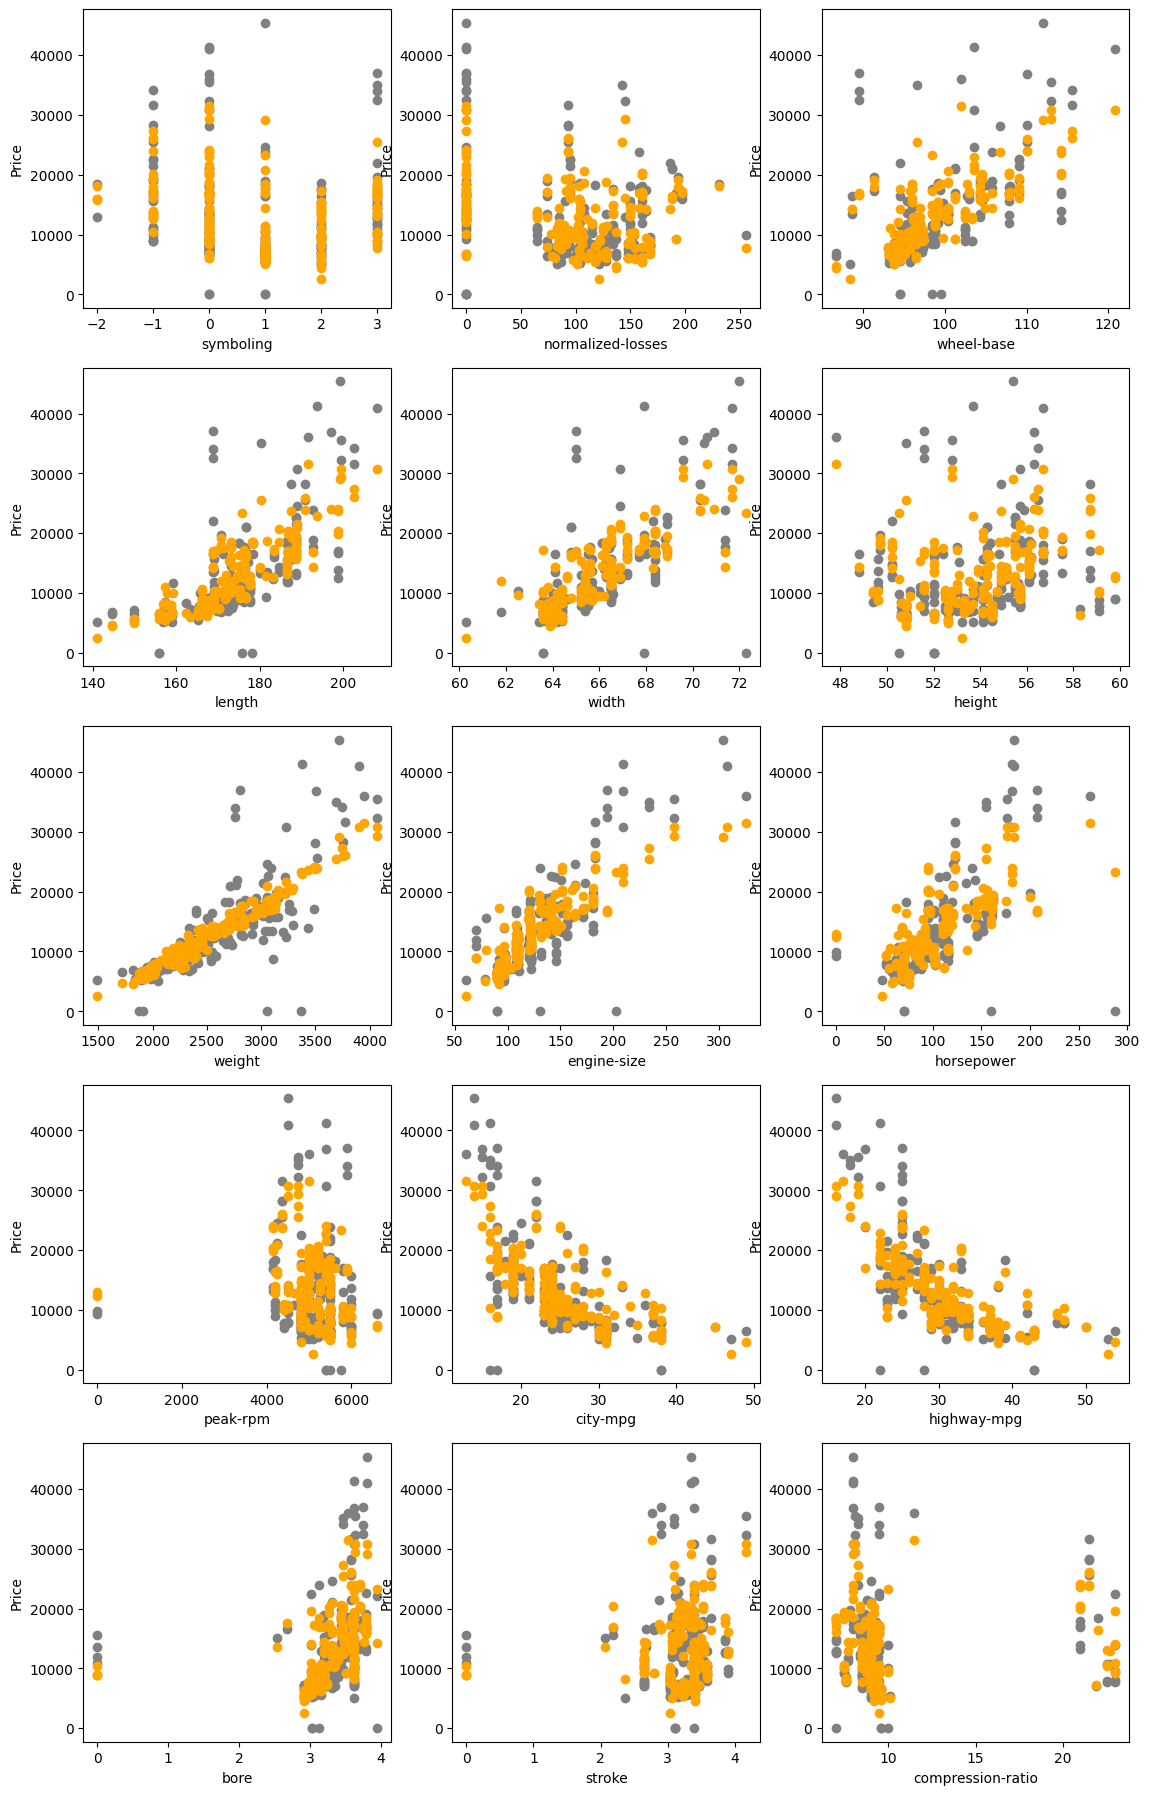

In [59]:
import matplotlib.pyplot as plt

# Define a function to plot the predictions of the model against each feature
def scatter_plot_inference_grid(est, x_df, feature_names):
  """
  Plots the predictions of the model against each feature.

  Args:
    est: The trained tf.Estimator.
    x_df: The pandas dataframe with the input data (used to create predict_input_fn).
    feature_names: An iterable of string feature names to plot.
  """
  # Define a helper function to generate one subplot
  def scatter_plot_inference(axis, x_axis_feature_name, predictions):
    """
    Generate one subplot.
    """
    # Plot the real data in grey
    axis.set_ylabel('Price')
    axis.set_xlabel(x_axis_feature_name)
    axis.scatter(car_data[x_axis_feature_name], car_data['price'], c='grey')

    # Plot the predicted data in orange
    axis.scatter(car_data[x_axis_feature_name], predictions, c='orange')

  # Create a predict input function
  predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False
  )

  # Get the predictions from the model
  predictions = [x['predictions'][0] for x in est.predict(predict_input_fn)]

  # Calculate the number of rows and columns for the subplot grid
  num_cols = 3
  num_rows = int(math.ceil(len(feature_names) / float(num_cols)))

  # Create the subplot grid
  f, axarr = plt.subplots(num_rows, num_cols)
  size = 4.5
  f.set_size_inches(num_cols * size, num_rows * size)

  # Iterate over the feature names and plot each one
  for i, feature_name in enumerate(feature_names):
    axis = axarr[int(i / num_cols), i % num_cols]
    scatter_plot_inference(axis, feature_name, predictions)

  # Show the plot
  plt.show()

# Call the function to plot the predictions
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 2: Take your best numeric model from earlier. Add normalization.

### Add normalization to your best numeric model from earlier

- You decide what type of normalization to add, and for which features
- You will need to use the `normalizer_fn` arg on [`numeric_column`](https://g3doc.corp.google.com/learning/brain/public/g3doc/api_docs/python/tf/feature_column/numeric_column.md?cl=head)
    - An example of a silly normalizer_fn that shifts inputs down by 1, and then negates the value:
    
         normalizer_fn = lambda x: tf.neg(tf.subtract(x, 1))

- You may find these pandas functions helpful:
    - dataframe.mean()['your_feature_name']
    - dataframe.std()['your_feature_name']
- You will need to retune the hyperparameters from earlier.


**Does normalization improve model quality on this dataset? Why or why not?**

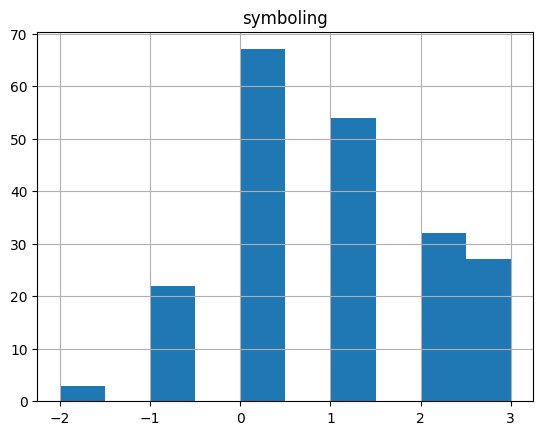

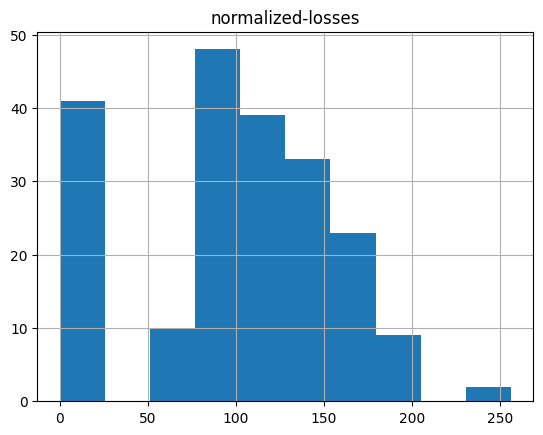

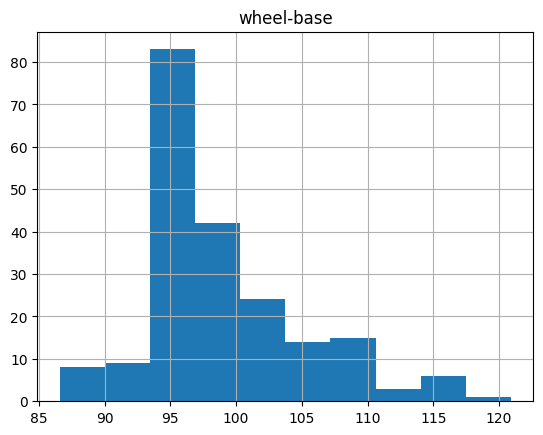

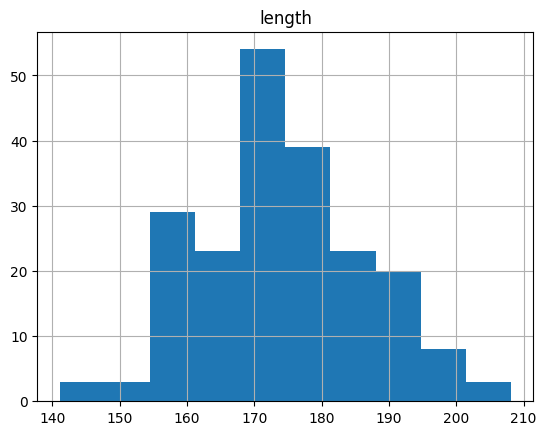

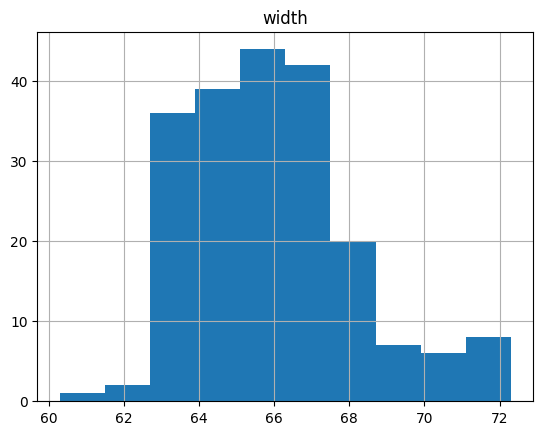

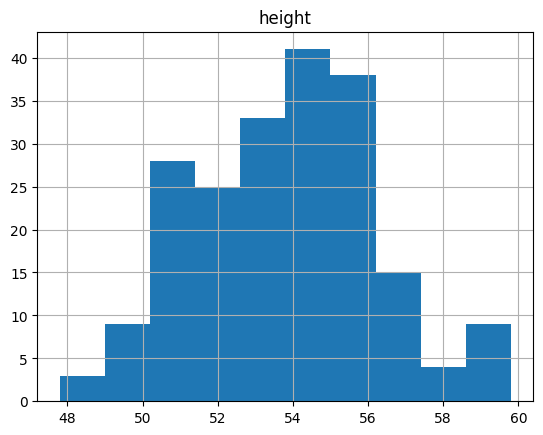

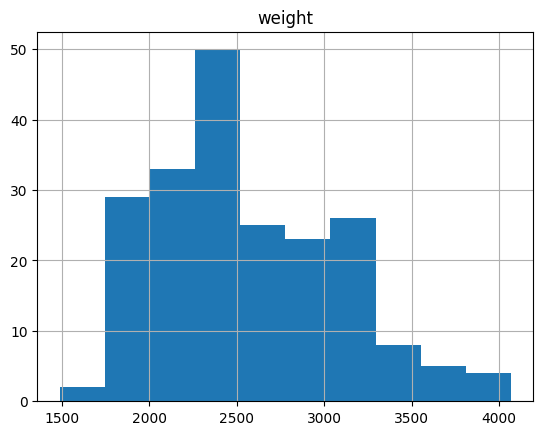

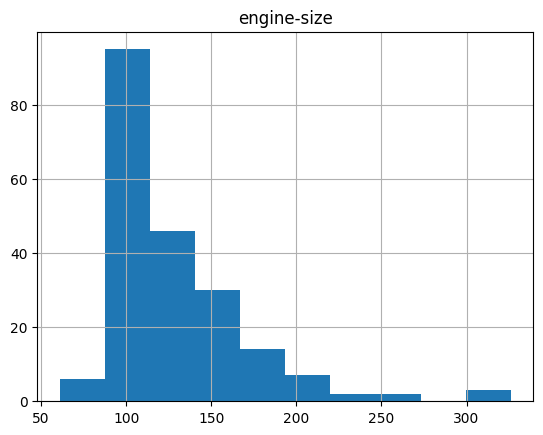

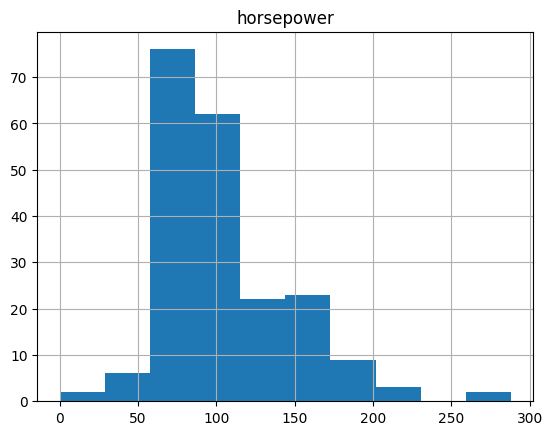

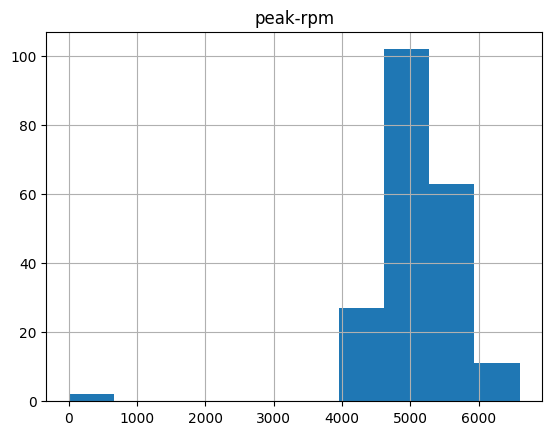

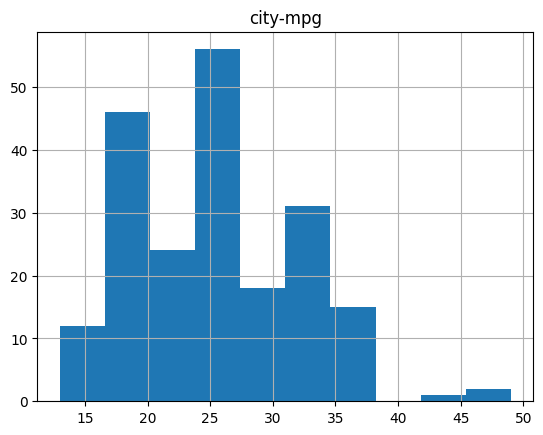

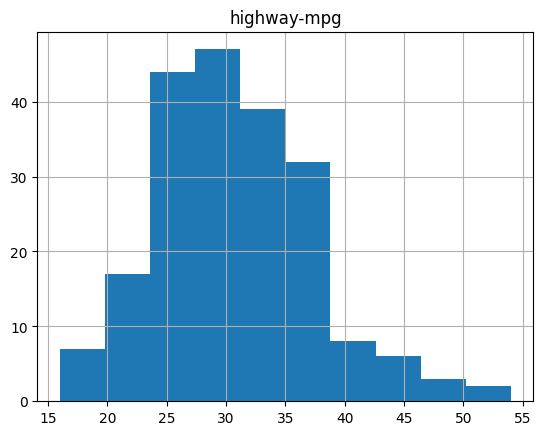

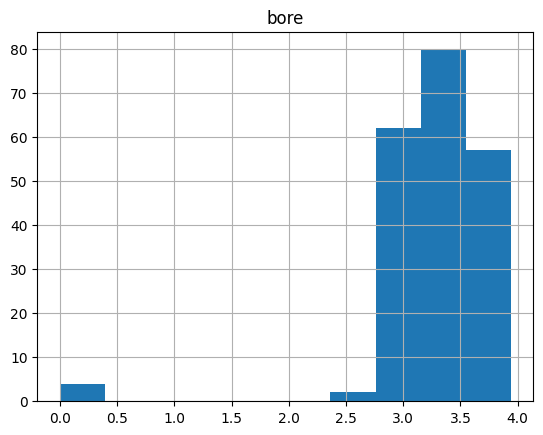

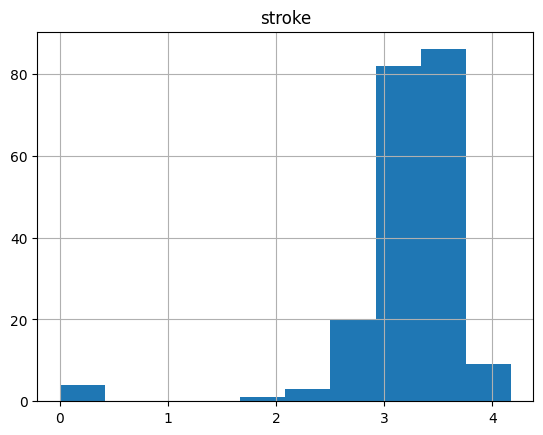

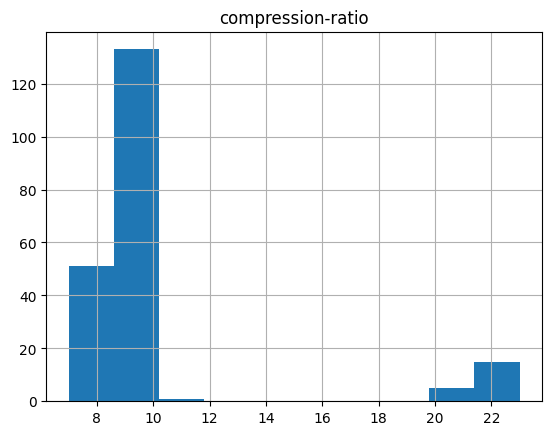

In [60]:
# This 1D visualization of each numeric feature might inform your normalization
# decisions.
for feature_name in numeric_feature_names:
  car_data.hist(column=feature_name)

###Train your model with numeric features + normalization

['symboling', 'normalized-losses', 'wheel-base', 'length', 'width', 'height', 'weight', 'engine-size', 'horsepower', 'peak-rpm', 'city-mpg', 'highway-mpg', 'bore', 'stroke', 'compression-ratio']
model_feature_columns [NumericColumn(key='symboling', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7d0c03bb2320>), NumericColumn(key='normalized-losses', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7d0c03bb2b90>), NumericColumn(key='wheel-base', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7d0c03bb2830>), NumericColumn(key='length', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7d0c03bb09d0>), NumericColumn(key='width', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=<function <listcomp>.<lambda> at 0x7d0c03bb2710>), NumericColumn(key='height', shape=(1,), default_va

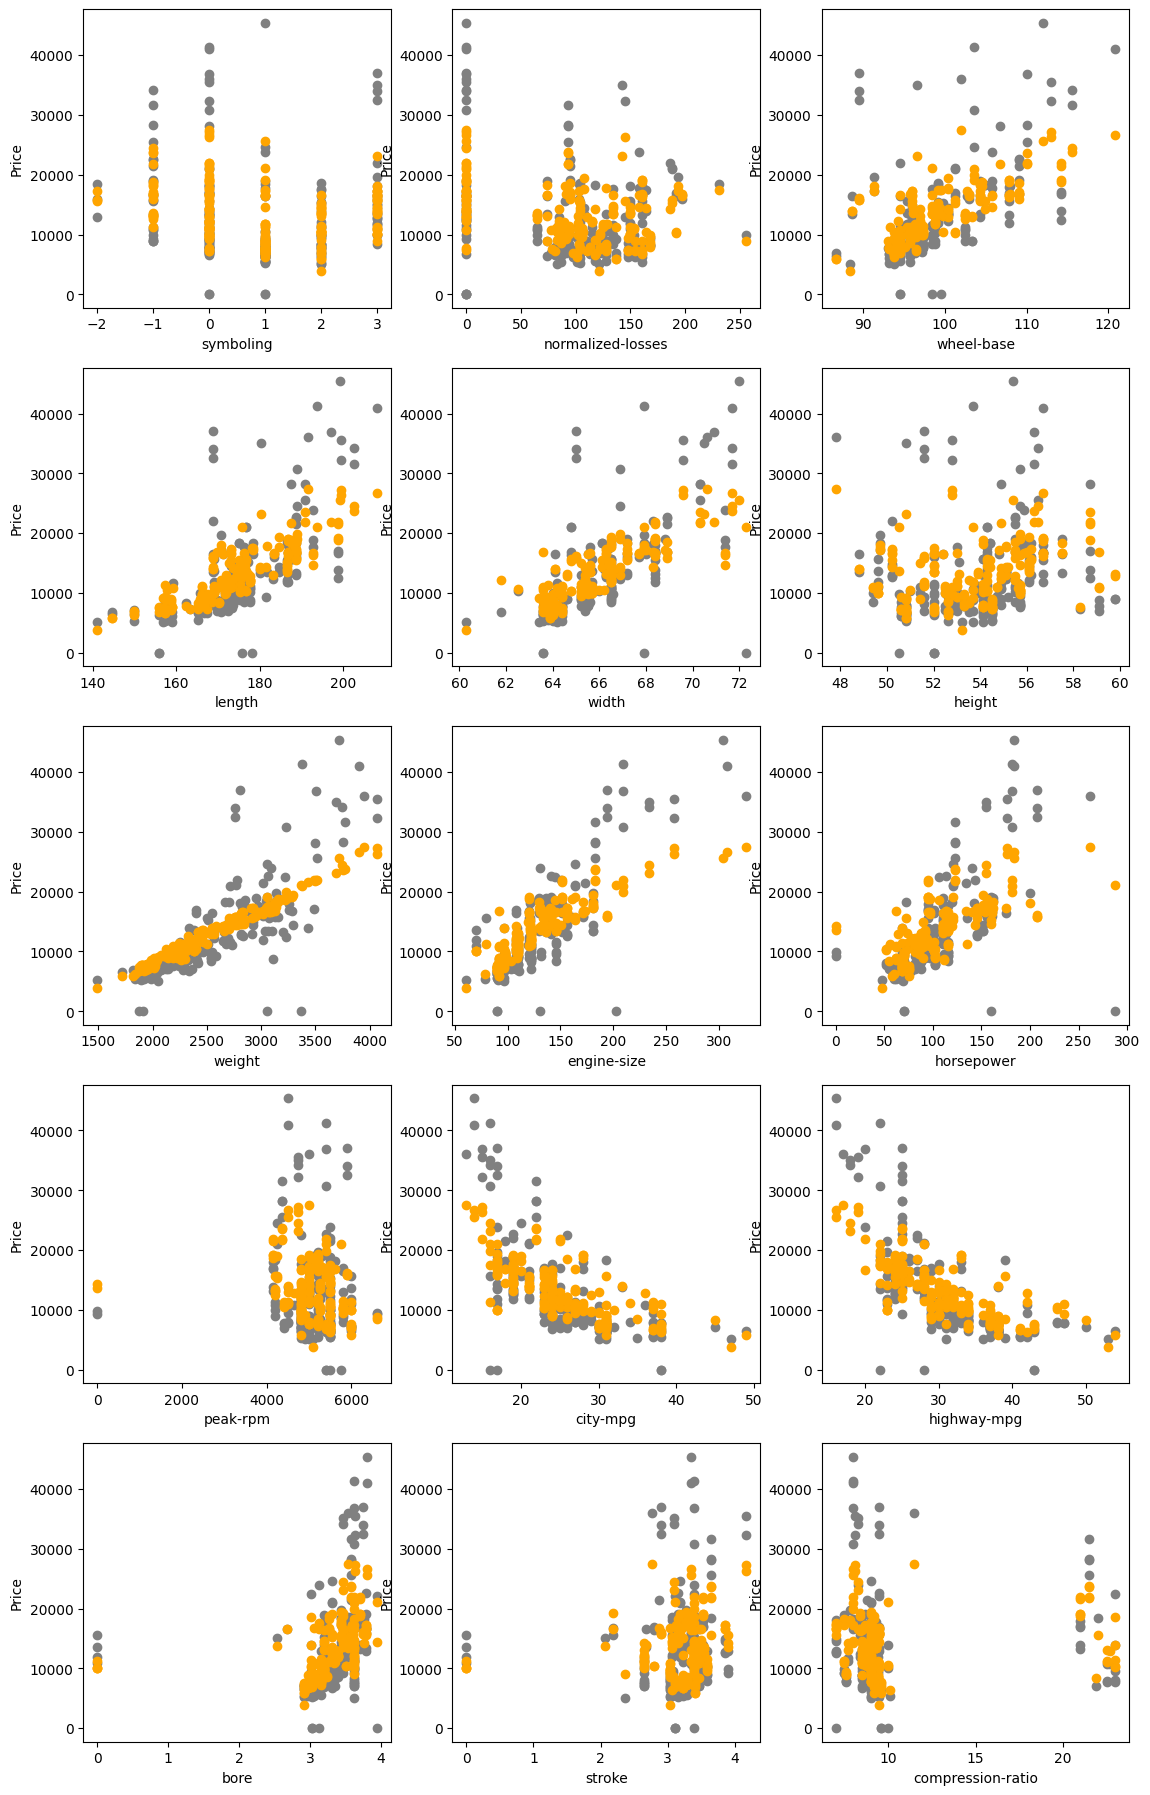

In [61]:
# Define the batch size for training and evaluation
batch_size = 16

# Select the numeric features and target variable from the dataset
print(numeric_feature_names)
x_df = car_data[numeric_feature_names]  # Features
y_series = car_data['price']  # Target variable

# Define input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,  # Train indefinitely
    shuffle=True  # Shuffle the data for training
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for evaluation
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for prediction
)

# Define a small value to prevent division by zero in normalization
epsilon = 0.000001

# Define feature columns with Z-score normalization
# Z-score normalization subtracts the mean and divides by the standard deviation,
# to give a roughly standard normal distribution (mean = 0, std = 1) under a
# normal distribution assumption.
model_feature_columns = [
    tf.feature_column.numeric_column(feature_name,
                                     # Normalize the feature using Z-score normalization
                                     normalizer_fn=lambda val: (val - x_df.mean()[feature_name]) / (epsilon + x_df.std()[feature_name]))
    for feature_name in numeric_feature_names
]
print('model_feature_columns', model_feature_columns)

# Define a DNNRegressor model with Adagrad optimizer
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],  # One hidden layer with 64 units
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

# Train the model in multiple stages, printing evaluation metrics at each stage
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # Print evaluation metrics
  # The `scores` dictionary contains metrics such as average loss and loss
  print('scores', scores)

# Visualize the model's predictions using a scatter plot
scatter_plot_inference_grid(est, x_df, numeric_feature_names)

## Task 3: Make your best model using only categorical features

- Look at the possible feature columns for categorical features. They begin with `categorical_column_with_` in go/tf-ops.
- You may find `dataframe[categorical_feature_names].unique()` helpful.


In [62]:
# Define the batch size for training and evaluation
batch_size = 16

# Select the categorical features and target variable from the dataset
x_df = car_data[categorical_feature_names]  # Categorical features
y_series = car_data['price']  # Target variable

# Define input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,  # Train indefinitely
    shuffle=True  # Shuffle the data for training
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for evaluation
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for prediction
)

# Define feature columns for categorical features using vocabulary lists
# We use categorical_column_with_vocabulary_list since we have the full list of
# values that each feature takes on, and the list is relatively small.
model_feature_columns = [
    tf.feature_column.indicator_column(
        # Create a categorical column with vocabulary list for each feature
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique())
    )
    for feature_name in categorical_feature_names
]
print('model_feature_columns', model_feature_columns)

# Define a DNNRegressor model with Adagrad optimizer
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],  # One hidden layer with 64 units
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

# Train the model in multiple stages, printing evaluation metrics at each stage
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
  est.train(train_input_fn, steps=num_training_steps // num_print_statements)
  scores = est.evaluate(eval_input_fn)

  # Print evaluation metrics
  # The `scores` dictionary contains metrics such as average loss and loss
  print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'dodge', 'nissan', 'mazda', 'plymouth', 'peugot', 'volkswagen', 'honda', 'volvo', 'saab', 'isuzu', 'mercedes-benz', 'subaru', 'porsche', 'audi', 'renault', 'chevrolet', 'mitsubishi', 'bmw', 'jaguar', 'alfa-romero', 'mercury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'ohcv', 'l', 'ohcf', 'dohc', 'rotor', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('std', 'turbo'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('2bbl', 'mpfi', 'idi', '1bbl', 'spfi', '4bbl', 'spdi', 'mfi'), dtype=tf.string, default_value=-1

## Task 4: Using all the features, make the best model that you can make

With all the features combined, your model should perform better than your earlier models using numerical and categorical models alone. Tune your model until that is the case.

In [63]:
# Define the batch size for training and evaluation
batch_size = 16

# Select the numeric and categorical features, and the target variable
x_df = car_data[numeric_feature_names + categorical_feature_names]
y_series = car_data['price']

# Define input functions for training, evaluation, and prediction
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    num_epochs=None,  # Train indefinitely
    shuffle=True  # Shuffle the data for training
)

eval_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    y=y_series,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for evaluation
)

predict_input_fn = tf.estimator.inputs.pandas_input_fn(
    x=x_df,
    batch_size=batch_size,
    shuffle=False  # Don't shuffle for prediction
)

# Define a small value to avoid division by zero
epsilon = 0.000001

# Create feature columns for categorical and numeric features
categorical_feature_columns = [
    tf.feature_column.indicator_column(
        tf.feature_column.categorical_column_with_vocabulary_list(
            feature_name, vocabulary_list=car_data[feature_name].unique())
    )
    for feature_name in categorical_feature_names
]

numeric_feature_columns = [
    tf.feature_column.numeric_column(
        feature_name,
        normalizer_fn=lambda val, feature_name=feature_name: (val - x_df[feature_name].mean()) / (epsilon + x_df[feature_name].std())
    )
    for feature_name in numeric_feature_names
]

model_feature_columns = categorical_feature_columns + numeric_feature_columns

print('model_feature_columns', model_feature_columns)

# Define a DNNRegressor model with Adagrad optimizer
est = tf.estimator.DNNRegressor(
    feature_columns=model_feature_columns,
    hidden_units=[64],  # One hidden layer with 64 units
    optimizer=tf.train.AdagradOptimizer(learning_rate=0.01)
)

# Train the model in multiple stages, printing evaluation metrics at each stage
num_print_statements = 10
num_training_steps = 10000
for _ in range(num_print_statements):
    est.train(train_input_fn, steps=num_training_steps // num_print_statements)
    scores = est.evaluate(eval_input_fn)

    # Print evaluation metrics
    print('scores', scores)

model_feature_columns [IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='make', vocabulary_list=('toyota', 'dodge', 'nissan', 'mazda', 'plymouth', 'peugot', 'volkswagen', 'honda', 'volvo', 'saab', 'isuzu', 'mercedes-benz', 'subaru', 'porsche', 'audi', 'renault', 'chevrolet', 'mitsubishi', 'bmw', 'jaguar', 'alfa-romero', 'mercury'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='engine-type', vocabulary_list=('ohc', 'ohcv', 'l', 'ohcf', 'dohc', 'rotor', 'dohcv'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='aspiration', vocabulary_list=('std', 'turbo'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='fuel-system', vocabulary_list=('2bbl', 'mpfi', 'idi', '1bbl', 'spfi', '4bbl', 'spdi', 'mfi'), dtype=tf.string, default_value=-1